## Hyper Params

In [1]:
Z_LENGTH = 64
MODEL = './assets/pretrained_models/celeba/last.ckpt'

## Define & Load Model

In [2]:
import tensorflow as tf
import numpy as np
from functools import partial

import arch
import dataset
import wae

x_ph = tf.placeholder(tf.float32,[None,64,64,3])
z_ph = tf.placeholder(tf.float32,[None,Z_LENGTH])

ds = dataset.CelebA(1)

p_z = arch.Pseudo_P_Z(z_ph)

Q_arch = partial(arch.enc_with_bn_arch,
                 input_shape=(64,64,3),
                 output_size=Z_LENGTH,
                 channel_nums=[128,256,512,1024])
G_arch = partial(arch.dec_with_bn_arch,
                 input_size=Z_LENGTH,
                 next_shape=(8,8,1024),
                 output_channel_num=3,
                 channel_nums=[512,256,128])
D_arch = partial(arch.fc_arch,
                 input_shape=(Z_LENGTH,), # shape when flattened.
                 output_size=1,
                 num_layers=4,
                 embed_size=512,
                 act_fn='ELU-like')

with tf.variable_scope('param_scope') as scope:
    pass

model = \
    wae.WAE_WGAN(x_ph,
                 p_z,
                 Q_arch,
                 G_arch,
                 D_arch,
                 0.0,
                 lambda x,y: tf.reduce_sum(tf.abs(x-y),axis=(1,2,3)), #use l1_distance for recon loss
                 None,
                 scope)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# Execute Training!
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

# Init variables and load weights
sess.run(init_op)
model.load(MODEL)

save vars:
/D/linear_0/b
/D/linear_0/w
/D/linear_1/b
/D/linear_1/w
/D/linear_2/b
/D/linear_2/w
/D/linear_3/b
/D/linear_3/w
/D/linear_4/b
/D/linear_4/w
/G/conv2d_3/b
/G/conv2d_3/w
/G/linear/b
/G/linear/w
/G/sym_conv2d_0/b
/G/sym_conv2d_0/w
/G/sym_conv2d_1/b
/G/sym_conv2d_1/w
/G/sym_conv2d_2/b
/G/sym_conv2d_2/w
/G/sym_conv2d_bn_0/bn/beta
/G/sym_conv2d_bn_0/bn/gamma
/G/sym_conv2d_bn_0/bn/moving_mean
/G/sym_conv2d_bn_0/bn/moving_variance
/G/sym_conv2d_bn_1/bn/beta
/G/sym_conv2d_bn_1/bn/gamma
/G/sym_conv2d_bn_1/bn/moving_mean
/G/sym_conv2d_bn_1/bn/moving_variance
/G/sym_conv2d_bn_2/bn/beta
/G/sym_conv2d_bn_2/bn/gamma
/G/sym_conv2d_bn_2/bn/moving_mean
/G/sym_conv2d_bn_2/bn/moving_variance
/Q/conv2d_0/b
/Q/conv2d_0/w
/Q/conv2d_1/b
/Q/conv2d_1/w
/Q/conv2d_2/b
/Q/conv2d_2/w
/Q/conv2d_3/b
/Q/conv2d_3/w
/Q/conv2d_bn_0/bn/beta
/Q/conv2d_bn_0/bn/gamma
/Q/conv2d_bn_0/bn/moving_mean
/Q/conv2d_bn_0/bn/moving_variance
/Q/conv2d_bn_1/bn/beta
/Q/conv2d_bn_1/bn/gamma
/Q/conv2d_bn_1/bn/moving_mean
/Q/conv2

## Reconstruction Result

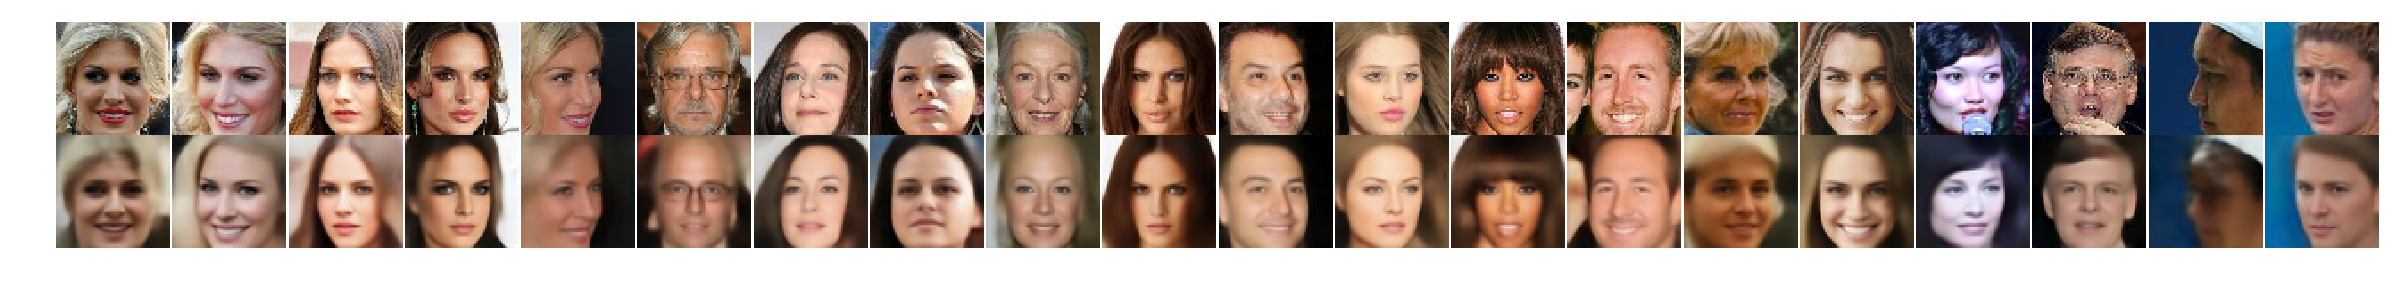

In [17]:
def draw(images):
    x,y,h,w,c = images.shape
    if c == 1:
        images = np.squeeze(images)
    
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(y,x),dpi=150)
    
    for i in range(x):
        for j in range(y):
            a = fig.add_subplot(x,y, (i*y+j) + 1)
            a.imshow( images[i,j] )
            a.axis('off')
            a.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()

sess.run(ds.valid_data_init_op)    
x = []
for _ in range(20):
    x.append( sess.run(ds.valid_data_op)[0] )
x = np.concatenate(x,axis=0)

recon_x = sess.run(model.x_recon, feed_dict={x_ph:x})

draw(np.stack([(x*255.0).astype(np.uint8),recon_x],axis=0))

(top): original images from CelebA validation set, (bottom): reconstructed image

## Random Sampled Images

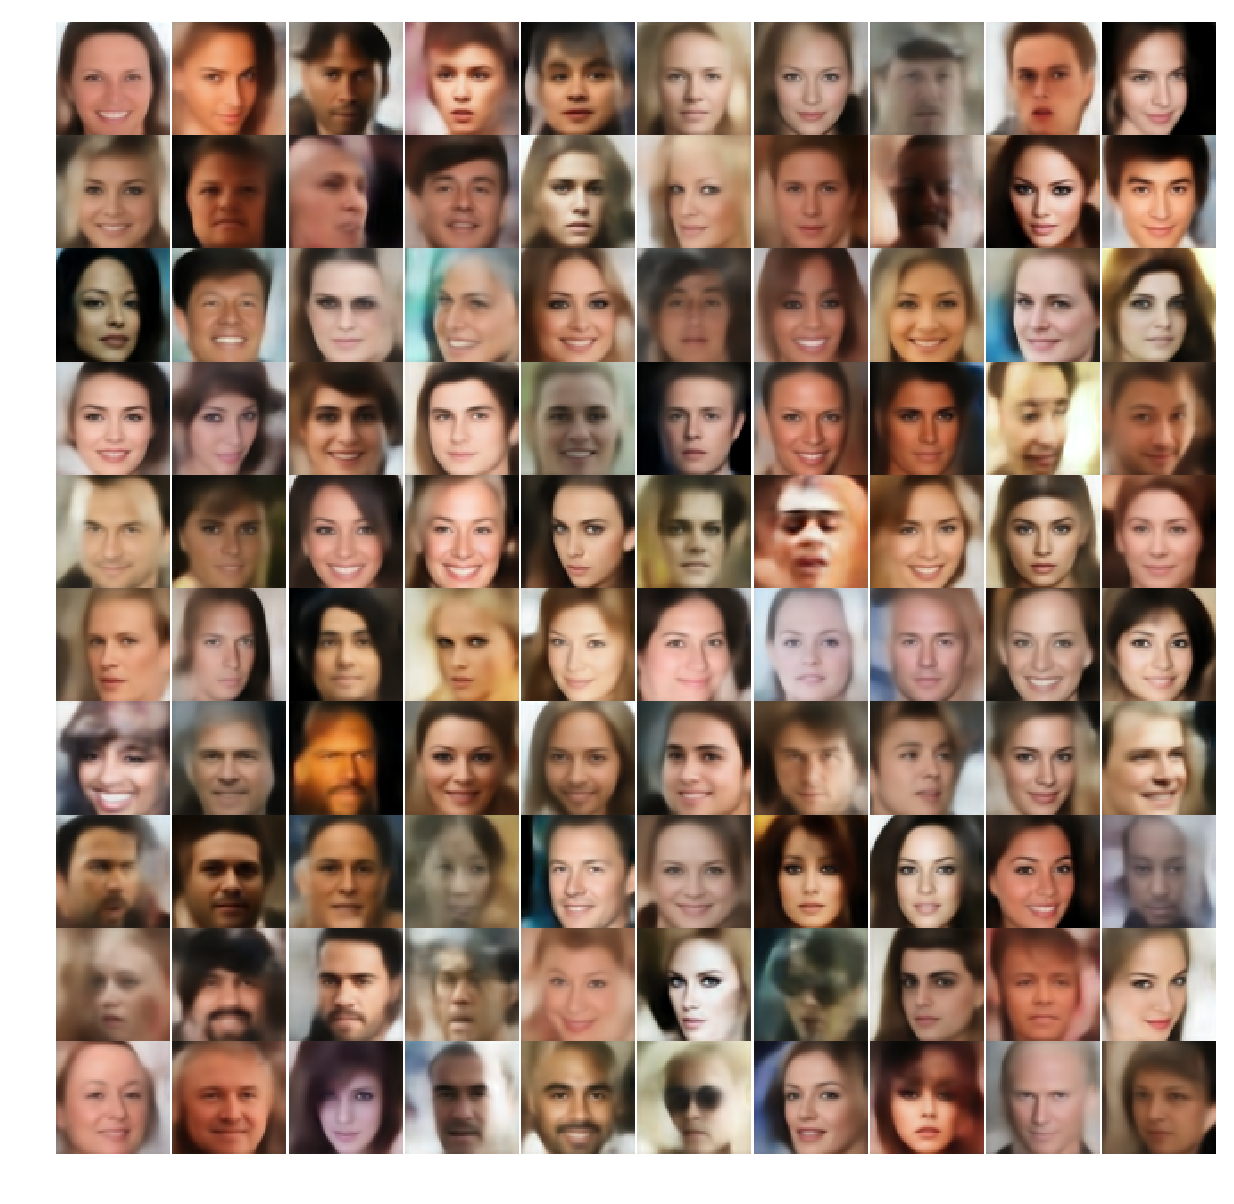

In [18]:
sampled = \
    sess.run(model.x_sample, 
         feed_dict={x_ph:np.zeros((100,64,64,3)), # Not used; just used for inferencing image shape
                    z_ph:np.random.normal(loc=0.0, scale=1.0, size=(100,Z_LENGTH))})
sampled = np.reshape(sampled,[10,10,64,64,3])
draw(sampled)

## Interpolation in Z space

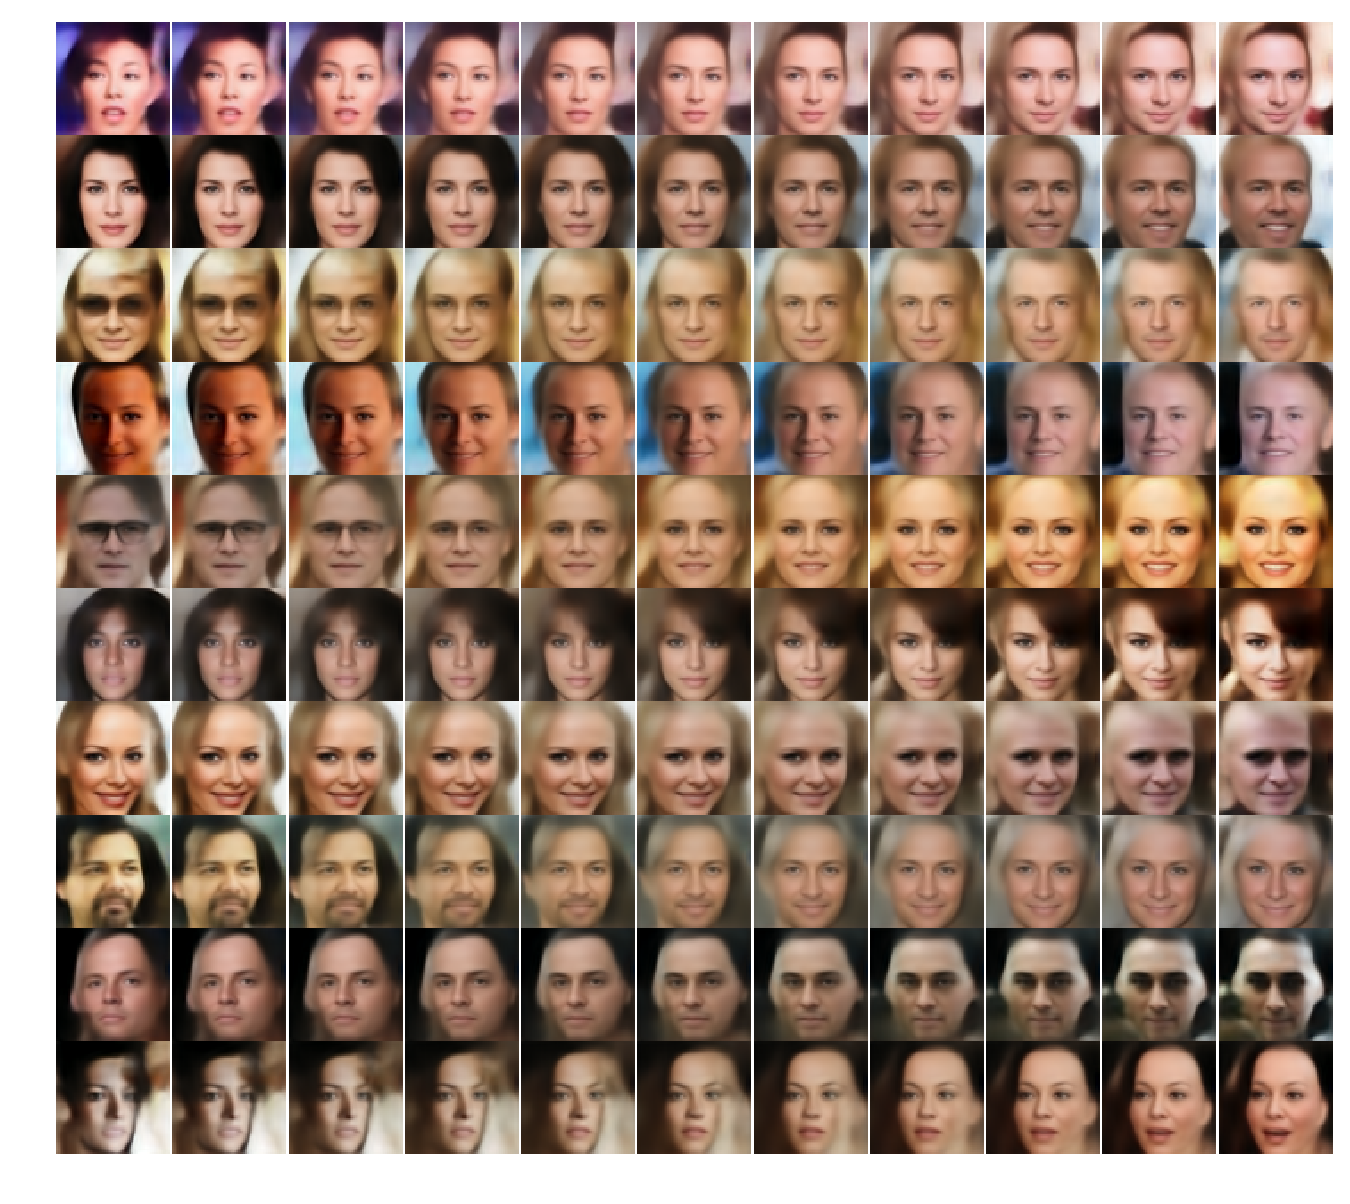

In [21]:
z = []
for _ in range(10):
    z_a,z_b = np.random.normal(loc=0.0, scale=1.0, size=(2,Z_LENGTH))
    zs = np.stack(
        [(1-alpha)*z_a + (alpha)*z_b for alpha in np.arange(0.0,1.1,0.1)],
        axis=0)
    z.append(zs)
z = np.stack(z,axis=0)

sampled = \
    sess.run(model.x_sample, 
         feed_dict={x_ph:np.zeros((z.shape[0]*z.shape[1],64,64,3)), # Not used; just used for inferencing image shape
                    z_ph:z.reshape(-1,Z_LENGTH)})
sampled = np.reshape(sampled,[z.shape[0],z.shape[1],64,64,3])
draw(sampled)